In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector
import numpy as np

from models.activation.exu import ExU
from models.activation.relu import LinearReLU
from models.featurenn import FeatureNN
from models.dnn import DNN
from models.nam import NAM
from config.default import defaults
from trainer.losses import *
from trainer.metrics import *
from trainer.trainer import Trainer
from data.toydataset import ToyDataset
from data.generator import *

from nam.models import FeatureNN as FN
from nam.models import NAM as NA
from nam.models import get_num_units
from nam.models.activation import ExU as Ex
from nam.models.activation import LinReLU
from nam.trainer.losses import penalized_loss as penloss
from nam.trainer.metrics import mae as MAE
from nam.trainer.metrics import accuracy as ACC

In [4]:
%reload_ext autoreload 
%autoreload 2

In [5]:
def reg_Xy(): 
    batch_size, in_features = 10, 3
    X = torch.rand(batch_size, in_features)
    fnn = torch.rand(batch_size, in_features)
    y = torch.rand(batch_size, 1)
    return X, y, fnn

def cls_Xy(): 
    batch_size, in_features = 10, 3
    X = torch.rand(batch_size, in_features)
    fnn = torch.rand(batch_size, in_features)
    y = torch.randint(0, 2, (batch_size, )).float()
    return X, y, fnn

reg_X, reg_y, reg_fnn = reg_Xy()
cls_X, cls_y, reg_fnn = cls_Xy()

In [6]:
def test_LinearReLU_shape():
    print("===Standard ReLU test===")
    n_inputs = 5 
    n_outputs = 3
    relu = LinearReLU(in_features=n_inputs, out_features=n_outputs)
    inputs = torch.randn(n_inputs)
    y = relu(inputs)
    assert len(y) == n_outputs, f"Wrong output length: {len(y)}"
    print(f"inputs: {inputs}, \noutputs: {y}")
    
def test_ExU_shape():
    # TODO
    print("===ExU test===")
    n_inputs = 5 
    n_outputs = 3
    exu = ExU(in_features=n_inputs, out_features=n_outputs)
    inputs = torch.randn(n_inputs)
    y = exu(inputs, 1)
    assert len(y) == n_outputs, f"Wrong output length: {len(y)}"
    print(f"inputs: {inputs}, \noutputs: {y}")
    
test_LinearReLU_shape()
test_ExU_shape()

===Standard ReLU test===
inputs: tensor([-0.1990, -0.5433, -0.4750, -0.0879, -0.4333]), 
outputs: tensor([0.4512, 0.0000, 0.0291], grad_fn=<ReluBackward0>)
===ExU test===
inputs: tensor([-0.2950, -0.7897,  1.0057,  0.0678, -0.4099]), 
outputs: tensor([0.1097, 0.0000, 1.0000], grad_fn=<ClampBackward1>)


/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-03/6a700484/lib/python3.10/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [8]:
def init_constant_parameters(m):    
    """set all model parameters as constant."""
    if isinstance(m, (nn.Linear, ExU, Ex, LinearReLU, LinReLU)):
        m.bias.data.fill_(0.01)
        if isinstance(m, nn.Linear):
            m.weight.data.fill_(0.1)
        else: 
            m.weights.data.fill_(0.1)

def test_featureNN(X, y):
    print("===Feature neural net test===")
    cfg = defaults()
    cfg.hidden_sizes = []
    in_features = X.shape[1]
    num_units = 32
    
    activation_cls = ['exu', 'relu']
    for a_cls in activation_cls:
        cfg.activation = a_cls
        fnn = FeatureNN(cfg, 'FNN', in_features, num_units, feature_index=1)
        sfnn = FN(config=cfg, name='SFNN', input_shape=in_features, num_units=num_units, feature_num=1)
        print(fnn)
        for name, param in fnn.named_parameters(): 
            print(name, param.shape)
        #print(vars(sfnn))
        #print(parameters_to_vector(fnn.parameters()).detach().shape, parameters_to_vector(sfnn.parameters()).detach().shape)

        fnn.apply(init_constant_parameters)
        sfnn.apply(init_constant_parameters)
        #np.testing.assert_allclose(parameters_to_vector(fnn.parameters()).detach(), parameters_to_vector(sfnn.parameters()).detach())

        outputs = fnn(X)
        soutputs = sfnn(X)
        np.testing.assert_allclose(outputs.detach(), soutputs.detach(), atol=1e-6)

        
test_featureNN(reg_X, reg_y)    

===Feature neural net test===
FeatureNN(
  (model): Sequential(
    (0): ExU(in_features=3, out_features=32)
    (1): Dropout(p=0, inplace=False)
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Dropout(p=0, inplace=False)
  )
)
model.0.weights torch.Size([3, 32])
model.0.bias torch.Size([3])
model.2.weight torch.Size([1, 32])
model.2.bias torch.Size([1])
FeatureNN(
  (model): Sequential(
    (0): LinearReLU(in_features=3, out_features=32)
    (1): Dropout(p=0, inplace=False)
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Dropout(p=0, inplace=False)
  )
)
model.0.weights torch.Size([3, 32])
model.0.bias torch.Size([3])
model.2.weight torch.Size([1, 32])
model.2.bias torch.Size([1])


/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-03/6a700484/lib/python3.10/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [9]:
def test_NAM(X, y):
    in_features = X.shape[1]
    cfg = defaults()
    nam = NAM(cfg, 'NAM', in_features, cfg.num_basis_functions)
    snam = NA(cfg, 'SNAM', num_inputs=in_features, num_units=cfg.num_basis_functions)
    nam.apply(init_constant_parameters)
    snam.apply(init_constant_parameters)
    np.testing.assert_allclose(parameters_to_vector(nam.parameters()).detach(), parameters_to_vector(snam.parameters()).detach())

    out, fnn = nam(X)
    sout, sfnn = snam(X)
    np.testing.assert_allclose(out.detach(), sout.detach())
    np.testing.assert_allclose(fnn.detach(), sfnn.detach())
            
        
test_NAM(reg_X, reg_y)

In [10]:
def test_penalized_loss(X, y, likelihood='regression'): 
    cfg = defaults()
    cfg.regression = True if likelihood == 'regression' else False
    in_features = X.shape[1]
    nam = NAM(cfg, 'NAM', in_features, cfg.num_basis_functions)
    snam = NA(cfg, 'SNAM', num_inputs=in_features, num_units=cfg.num_basis_functions)
    nam.apply(init_constant_parameters)
    snam.apply(init_constant_parameters)
    
    out, fnn = nam(X)
    sout, sfnn = snam(X)
    if likelihood == 'classification': 
        m = nn.Sigmoid()
        out = m(out)
        sout = m(sout)
    criti = lambda out, targets, fnn: penalized_loss(cfg, out, fnn, nam, targets)
    scriti = lambda targets, out, fnns_out: penloss(
            cfg, out, targets, weights=None, fnn_out=fnns_out, model=snam)

    loss = criti(out, y, fnn)
    sloss = scriti(y, out, fnn)
    np.testing.assert_allclose(loss.detach(), sloss.detach())
    
    
test_penalized_loss(reg_X, reg_y)
test_penalized_loss(cls_X, cls_y, 'classification')

In [11]:
def test_metrics(X, y, likelihood='regression'): 
    cfg = defaults()
    cfg.regression = True if likelihood == 'regression' else False
    in_features = X.shape[1]
    nam = NAM(cfg, 'NAM', in_features, cfg.num_basis_functions)
    snam = NA(cfg, 'SNAM', num_inputs=in_features, num_units=cfg.num_basis_functions)
    nam.apply(init_constant_parameters)
    snam.apply(init_constant_parameters)
    
    out, fnn = nam(X)
    sout, sfnn = snam(X)
    if likelihood == 'classification': 
        m = nn.Sigmoid()
        out = m(out)
        sout = m(sout)
    
    metrics = lambda out, targets: mae(out, targets) if likelihood=='regression' else accuracy(out, targets)
    smetrics = lambda out, targets: MAE(out, targets) if likelihood=='regression' else ACC(out, targets)
     
    met = metrics(out, y)
    smet = smetrics(out, y)
    np.testing.assert_allclose(met, smet)
    
    
test_metrics(reg_X, reg_y)
test_metrics(cls_X, cls_y, 'classification')

0.7


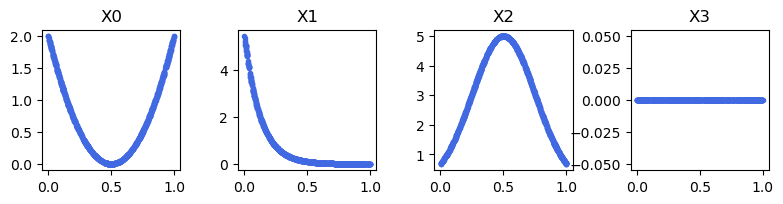

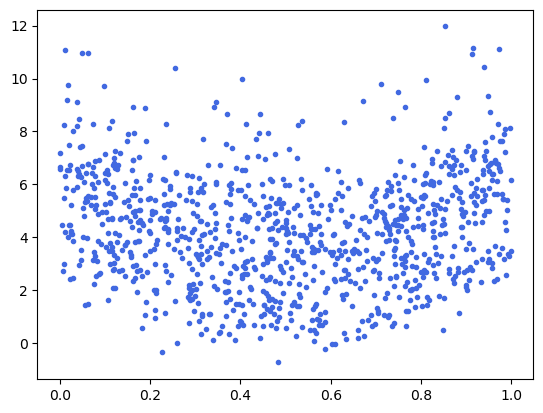

In [12]:
cfg = defaults()

gen_funcs, gen_func_names = task()
in_features = len(gen_funcs)
sigma = cfg.prior_sigma_noise
print(sigma)
trainset = ToyDataset(gen_funcs, gen_func_names, num_samples=1000, sigma=sigma)
trainset.plot()

train_loader, train_loader_fnn = trainset.loader, trainset.loader_fnn